In [1]:
#standard packages
import numpy as np
from numpy import concatenate
import pandas as pd
import glob
import math
import warnings

#plot packages
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

#package to create date-time objects
import datetime as dt

#performance measures
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

from timeit import default_timer as timer
from datetime import timedelta
import tensorflow as tf
from tqdm import tqdm
from IPython.utils import io

import warnings
warnings.filterwarnings("ignore")

def _naive_forecasting(actual: np.ndarray, seasonality):
    return actual[:-seasonality]

def _naive_forecasting_test(actual: np.ndarray, seasonality, test):
    forecast=[]
    for j in range(0, len(test), seasonality):
        forecast.append(actual[-seasonality:])
    forecast = [item for sublist in forecast for item in sublist]
    return forecast[:len(test)]

def mean_absolute_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))

def mean_absolute_scaled_error_test(actual: np.ndarray, predicted: np.ndarray, seasonality, actual_train):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual, _naive_forecasting_test(actual_train, seasonality, actual))

def mean_absolute_scaled_error_test2(actual: np.ndarray, predicted: np.ndarray, seasonality, actual_train):
    #Baseline (benchmark) is computed with naive forecasting shifted bu seasonality
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual_train[seasonality:], _naive_forecasting(actual_train, seasonality))

def mean_directional_accuracy(y, y_hat):
    #Mean Directional Accuracy
    return np.mean(np.sign(y.diff()[1:]) == np.sign(y_hat.diff()[1:]))
    # the reason the two diffrence are diffrentely computed is because y is inputed as dataframe column but yhat is a array. 
    #If this is diffrent then change.
    
#RF packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn import tree

pd.options.mode.chained_assignment = None  # default='warn'
# import random 
import random

#prophet packages
from prophet import Prophet

#LSTM packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#SARIMAX packages
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima                        
import warnings
from itertools import product
from tqdm import tqdm_notebook

import seaborn as sns

In [2]:
def preformance_measures(pred, len_trainset, S):
    y_true_train = pred.y[:len_trainset]
    y_true_test = pred.y[len_trainset:]
    y_pred_train = pred.Forecast[:len_trainset]
    y_pred_test = pred.Forecast[len_trainset:]

    MAEtrain = mean_absolute_error(y_true_train, y_pred_train)
    MAEtest = mean_absolute_error(y_true_test, y_pred_test)
    
    RMSEtrain = mean_squared_error(y_true_train, y_pred_train, squared=False)
    RMSEtest = mean_squared_error(y_true_test, y_pred_test, squared=False)

    MedAEtrain = median_absolute_error(y_true_train, y_pred_train)
    MedAEtest = median_absolute_error(y_true_test, y_pred_test)

    MASEtrain = mean_absolute_scaled_error(y_true_train, y_pred_train, S)
    MASEtest = mean_absolute_scaled_error_test2(y_true_test, y_pred_test, S, y_true_train)
        
    MDAtrain = mean_directional_accuracy(y_true_train, y_pred_train)
    MDAtest= mean_directional_accuracy(y_true_test, y_pred_test)

    results=[]
    results = pd.DataFrame(data= {'MEA': [round(MAEtrain, 3), round(MAEtest,3)],
                                  ' RMSE': [round(RMSEtrain, 3), round(RMSEtest,3)],
                                    'MedAE': [round(MedAEtrain, 3), round(MedAEtest,3)],
                                    'MASE': [round(MASEtrain, 3), round(MASEtest,3)],
                                    'MDA': [round(MDAtrain, 3), round(MDAtest,3)],})
    
    return results

In [3]:
def time_dummies(df):
    df['hour'] = df['ds'].dt.hour
    df['weekday'] =df['ds'].dt.weekday
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    
    kerst = pd.DataFrame({
      'ds': pd.to_datetime(['2019-01-01', '2019-01-02', '2019-01-03',
                        '2019-01-04', '2019-01-05', '2019-01-06'
                        ]),
    })
    voorjaar = pd.DataFrame({
      'ds': pd.to_datetime(['2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23',
               '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03']),
    })
    mei = pd.DataFrame({
      'ds': pd.to_datetime(['2019-04-27', '2019-04-28', '2019-04-29', '2019-04-30',
               '2019-05-01', '2019-05-02', '2019-05-03', '2019-05-04',
               '2019-05-05'
                        ])
    })
    zomer = pd.DataFrame({
      'ds': pd.to_datetime(['2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09',
               '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13',
               '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17',
               '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-27', '2019-07-28', '2019-07-29',
               '2019-07-30', '2019-07-31', '2019-08-01', '2019-08-02',
               '2019-08-03', '2019-08-04', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
               '2019-08-15', '2019-08-16', '2019-08-17', '2019-08-18',
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01'
                        ]),
    })
    herfst= pd.DataFrame({
      'ds': pd.to_datetime(['2019-10-12', '2019-10-13', '2019-10-14', '2019-10-15',
               '2019-10-16', '2019-10-17', '2019-10-18', '2019-10-19',
               '2019-10-20', '2019-10-21', '2019-10-22', '2019-10-23',
               '2019-10-24', '2019-10-25', '2019-10-26', '2019-10-27'
                        ]),
    })
    kerst2= pd.DataFrame({
      'ds': pd.to_datetime(['2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-28',
               '2019-12-29', '2019-12-30', '2019-12-31'
                        ]),
    })

    holidays = pd.concat((kerst,voorjaar,mei,zomer,herfst, kerst2))
    df['Holiday'] = df['ds'].dt.date.astype('datetime64').isin(holidays.ds).astype('uint8')
    
    return df

# LSTM

In [4]:
# convert series to supervised learning
def series_to_supervised(data, number_of_regressors, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    agg.drop(agg.columns[range(number_of_regressors+1, 2*number_of_regressors)], axis=1, inplace=True)
    return agg

In [5]:
def LSTM_fun(df, len_trainset):
    df = time_dummies(df)
    df.ds = pd.to_datetime(df.ds)
    
    dfLSTM = df.set_index('ds')
    first_column = dfLSTM.pop('y')
    dfLSTM.insert(0, 'y', first_column)
    
    number_of_regressors =  dfLSTM.shape[1]
    # load dataset
    dataset = dfLSTM
    values = dataset.values
    # integer encode direction
    encoder = LabelEncoder()
    values[:,1] = encoder.fit_transform(values[:,1])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, number_of_regressors,1, 1)
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = len_trainset
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    start = timer()
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    with io.capture_output() as captured:
        history = model.fit(train_X, train_y,  epochs=300, batch_size=64, validation_data=(test_X, test_y), 
                            verbose=1, shuffle=False)
        
    
    # split into train and test sets
    values = reframed.values
    train = values[:len_trainset, :]
    test = values[len_trainset:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    #traindata
    Train = dfLSTM.iloc[1:len_trainset+1,:]
    #test data
    Test = dfLSTM.iloc[len_trainset+1:,:]
    
    test_norm = pd.DataFrame(test_X)
    test_norm.columns = Test.columns
    test_norm['ds'] = Test.index
    test_norm = test_norm.set_index('ds')

    train_norm = pd.DataFrame(train_X)
    train_norm.columns = Train.columns
    train_norm['ds'] = Train.index
    train_norm = train_norm.set_index('ds')
    
    # make a prediction
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    yhat_train = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

    yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
    yhat_train_inv = scaler.inverse_transform(yhat_train)[:,0]
    
    # make a forecast
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    yhat_test = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    yhat_test = concatenate((yhat_test, test_X[:, 1:]), axis=1)
    yhat_test_inv = scaler.inverse_transform(yhat_test)[:,0]
    

    end = timer()
    runtime = end-start
    print(round(runtime,2))
    
    
    y_true_train = dfLSTM['y'][:len_trainset]
    y_true_test = dfLSTM['y'][len_trainset:-1]
    y_pred_train = yhat_train_inv.reshape(-1)
    y_pred_test = yhat_test_inv.reshape(-1)
    
    
    yhat_inv_total = np.concatenate((y_pred_train, y_pred_test), axis=0)
    yhat_true_total = np.concatenate((y_true_train, y_true_test), axis=0)
    
    dfLSTM = dfLSTM.reset_index()
    results_LSTM = pd.concat((dfLSTM[['ds', 'y']][:-1],pd.DataFrame(data = {'Forecast': yhat_inv_total})), axis=1)
    return results_LSTM

# Results

In [6]:
df = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\half_hour.txt', sep="\t")
df.date = pd.date_range(df.date[0] , periods = len(df.date), freq='30min')
df.rename(columns={'date' : 'ds', 'count' : 'y'}, inplace=True)
df.drop(['AvgService'], axis=1, inplace=True)

In [7]:
len_trainset=round(0.8*len(df))

In [8]:
results_LSTM = LSTM_fun(df, len_trainset)

97/97 [==============================] - 0s 699us/step
101.52


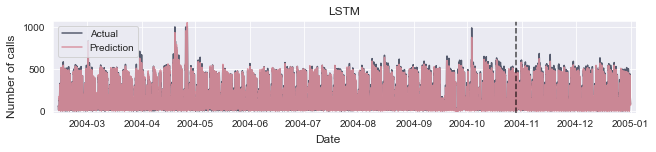

In [10]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, constrained_layout=True, figsize=(9, 2))

ax.set_title('LSTM')
ax.plot(np.asarray(results_LSTM.ds, dtype='datetime64[s]'), results_LSTM.y, color= '#555B6E', label = 'Actual')
ax.plot(np.asarray(results_LSTM.ds[1:], dtype='datetime64[s]'), results_LSTM.Forecast[1:], label = 'Prediction', alpha=0.9, color= '#D88C9A')
ax.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
ax.margins(x=0.01)
ax.margins(y=0.02)
ax.legend(loc="upper left")

fig.supxlabel('Date')
fig.supylabel('Number of calls')

plt.savefig(r'C:\Users\Britt\Documents\callcenter_results_overall_oneStepAhead.pdf', format="pdf", bbox_inches="tight")  

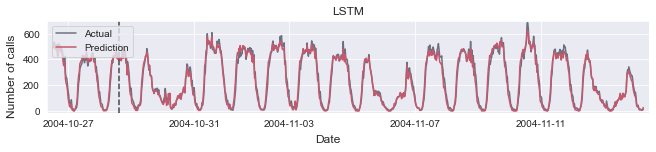

In [11]:
zoom1 = 100 #amount of observation from the train set you see
zoom2 = 800 #amount of observation from test you see
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True,  constrained_layout=True, figsize=(9, 2))

ax.set_title('LSTM')
ax.plot(np.asarray(results_LSTM.ds[len_trainset-zoom1:len_trainset+zoom2], dtype='datetime64[s]'), results_LSTM.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual', alpha=0.85)
ax.plot(np.asarray(results_LSTM.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], results_LSTM.Forecast[len_trainset-zoom1:len_trainset+zoom2], label = 'Prediction', alpha=1, color= '#C6586C')
ax.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
ax.legend(loc="upper left")
ax.margins(x=0.01)
ax.margins(y=0.02)
ax.set_xticks(ax.get_xticks()[::2])

fig.supxlabel('Date')
fig.supylabel('Number of calls')

plt.savefig(r'C:\Users\Britt\Documents\callcenter_results_zoom_onestepahead.pdf', format="pdf", bbox_inches="tight")  

# Performance measures

In [28]:
print(preformance_measures(results_LSTM, len_trainset, 48))

      MEA    RMSE   MedAE   MASE    MDA
0  20.824  28.789  13.959  0.247  0.930
1  22.811  31.116  14.508  0.271  0.917
